# `featurize_races_weather.ipynb`

### Author: Anthony Hein

#### Last updated: 10/20/2021

# Overview:

Upon further consideration, we should indeed bin the weather data to capture non-linear interactions between weather and the rest of the data. That is, binning helps the model learn a "sweet spot" instead of a linear trend, which we cannot be sure exists in weather data.

---

## Setup

In [1]:
from datetime import datetime
import git
import os
import re
import math
from typing import List
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `races_featurized.csv`

In [3]:
races_featurized = pd.read_csv(f"{BASE_DIR}/data/csv/races_featurized.csv", low_memory=False) 
races_featurized.head()

,rid,metric,margin,temp,msl,rain,rhum,course__Ballinrobe,course__Bellewstown,course__Clonmel,...,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,year
0,302858,3821.0,1.219263,2.2,1012.7,0.0,82,0,0,0,...,0,0,0,0,0,0,0,0,0,1997
1,291347,5229.0,1.218049,8.1,992.8,0.0,79,0,0,0,...,0,0,0,0,0,0,0,0,0,1997
2,377929,1609.0,1.204927,10.1,996.7,0.0,76,0,0,0,...,0,1,0,0,0,0,0,0,0,1997
3,275117,2011.0,1.083838,15.8,1030.1,0.0,53,0,0,0,...,0,1,0,0,0,0,0,0,0,1997
4,66511,1810.0,1.077871,16.3,1022.9,0.0,53,0,0,0,...,0,0,1,0,0,0,0,0,0,1997


In [4]:
races_featurized.shape

(19248, 70)

In [5]:
races_featurized_weather = races_featurized.copy()
races_featurized_weather.head()

,rid,metric,margin,temp,msl,rain,rhum,course__Ballinrobe,course__Bellewstown,course__Clonmel,...,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,year
0,302858,3821.0,1.219263,2.2,1012.7,0.0,82,0,0,0,...,0,0,0,0,0,0,0,0,0,1997
1,291347,5229.0,1.218049,8.1,992.8,0.0,79,0,0,0,...,0,0,0,0,0,0,0,0,0,1997
2,377929,1609.0,1.204927,10.1,996.7,0.0,76,0,0,0,...,0,1,0,0,0,0,0,0,0,1997
3,275117,2011.0,1.083838,15.8,1030.1,0.0,53,0,0,0,...,0,1,0,0,0,0,0,0,0,1997
4,66511,1810.0,1.077871,16.3,1022.9,0.0,53,0,0,0,...,0,0,1,0,0,0,0,0,0,1997


---

## Bin the Temperature

We will make the very conscious decision here to make 5 different bins for the temperature, where we will let MatPlotLib `hist()` function decide the bins. The choice of 5 bins is because we hope that they will translate to:
* cold
* chilly
* comfortable
* warm
* hot

(array([  174.,  2839., 10141.,  5890.,   204.]),
 array([-6.2 ,  1.14,  8.48, 15.82, 23.16, 30.5 ]),
 <BarContainer object of 5 artists>)

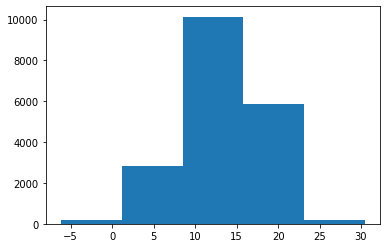

In [6]:
plt.hist(races_featurized['temp'], bins=5)

In [7]:
# cutoffs obtained from the histogram
temp_cutoffs = [-6.2, 1.14, 8.48, 15.82, 23.16, 30.5]

In [8]:
for idx in range(len(temp_cutoffs[:-1])):
    colname = "temp_level_" + str(idx)
    in_bucket = np.logical_and(races_featurized_weather['temp'] > temp_cutoffs[idx],
                               races_featurized_weather['temp'] < temp_cutoffs[idx + 1])
    races_featurized_weather[colname] = [int(elt) for elt in in_bucket]
    
races_featurized_weather.head(10)

,rid,metric,margin,temp,msl,rain,rhum,course__Ballinrobe,course__Bellewstown,course__Clonmel,...,month__9,month__10,month__11,month__12,year,temp_level_0,temp_level_1,temp_level_2,temp_level_3,temp_level_4
0,302858,3821.0,1.219263,2.2,1012.7,0.0,82,0,0,0,...,0,0,0,0,1997,0,1,0,0,0
1,291347,5229.0,1.218049,8.1,992.8,0.0,79,0,0,0,...,0,0,0,0,1997,0,1,0,0,0
2,377929,1609.0,1.204927,10.1,996.7,0.0,76,0,0,0,...,0,0,0,0,1997,0,0,1,0,0
3,275117,2011.0,1.083838,15.8,1030.1,0.0,53,0,0,0,...,0,0,0,0,1997,0,0,1,0,0
4,66511,1810.0,1.077871,16.3,1022.9,0.0,53,0,0,0,...,0,0,0,0,1997,0,0,0,1,0
5,337765,2011.0,1.102020,15.5,992.0,0.0,85,0,0,0,...,0,0,0,0,1997,0,0,1,0,0
6,353432,1407.0,1.178877,14.0,1004.5,0.0,94,0,0,0,...,0,0,0,0,1997,0,0,1,0,0
7,362433,2011.0,1.168184,15.7,1010.1,0.0,71,0,0,0,...,0,0,0,0,1997,0,0,1,0,0
8,326282,1206.0,1.153438,15.0,1012.0,0.0,76,0,0,0,...,0,0,0,0,1997,0,0,1,0,0
9,42648,2815.0,1.243313,16.1,1010.9,0.0,75,0,0,0,...,0,0,0,0,1997,0,0,0,1,0


---

## Bin Pressure

Again, to follow convention we will make 5 bins for pressure.

(array([   40.,   574.,  5649., 11559.,  1426.]),
 array([ 956.  ,  973.88,  991.76, 1009.64, 1027.52, 1045.4 ]),
 <BarContainer object of 5 artists>)

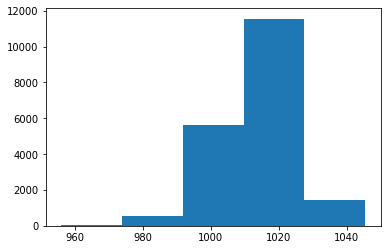

In [9]:
plt.hist(races_featurized['msl'], bins=5)

In [10]:
# cutoffs obtained from the histogram
pressure_cutoffs = [956., 973.88, 991.76, 1009.64, 1027.52, 1045.4]

In [11]:
for idx in range(len(temp_cutoffs[:-1])):
    colname = 'pressure_level_' + str(idx)
    in_bucket = np.logical_and(races_featurized_weather['msl'] > pressure_cutoffs[idx],
                               races_featurized_weather['msl'] < pressure_cutoffs[idx + 1])
    races_featurized_weather[colname] = [int(elt) for elt in in_bucket]

races_featurized_weather.sample(10)

,rid,metric,margin,temp,msl,rain,rhum,course__Ballinrobe,course__Bellewstown,course__Clonmel,...,temp_level_0,temp_level_1,temp_level_2,temp_level_3,temp_level_4,pressure_level_0,pressure_level_1,pressure_level_2,pressure_level_3,pressure_level_4
3408,406118,2011.0,1.163230,22.6,1013.0,0.0,71,0,0,0,...,0,0,0,1,0,0,0,0,1,0
12513,299153,1709.5,1.063492,11.1,1029.5,0.0,77,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4389,297434,1609.0,1.108824,5.4,1011.3,0.0,46,0,0,0,...,0,1,0,0,0,0,0,0,1,0
8073,321382,3821.0,1.233565,19.3,1025.5,0.0,61,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4430,351268,1005.0,1.253664,8.6,1002.9,0.0,66,0,0,0,...,0,0,1,0,0,0,0,1,0,0
7276,217042,1609.0,1.216000,16.2,1029.3,0.0,96,0,0,0,...,0,0,0,1,0,0,0,0,0,1
10742,2491,1709.5,1.221035,14.4,1014.8,0.1,80,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2067,50869,1206.0,1.218661,12.8,1005.3,0.0,74,0,0,0,...,0,0,1,0,0,0,0,1,0,0
7751,339931,1609.0,1.177525,5.5,1018.8,0.0,58,0,0,0,...,0,1,0,0,0,0,0,0,1,0
14925,378717,3419.0,1.281078,17.6,1018.2,0.0,86,0,0,0,...,0,0,0,1,0,0,0,0,1,0


---

## Bin Rain

We can actually won't just choose a cutoff based on 5 bins, since rain is less of a distribution with a center and more of something that is assumed to be zero unless otherwise noted. Let's understand how much rain there is.

In [12]:
races_featurized_weather['rain'].value_counts()

0.0    16319
0.1      730
0.2      437
0.3      288
0.4      220
       ...  
4.5        1
7.3        1
4.6        1
5.0        1
6.8        1
Name: rain, Length: 65, dtype: int64

(array([1.8914e+04, 2.4800e+02, 5.2000e+01, 2.3000e+01, 5.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <BarContainer object of 10 artists>)

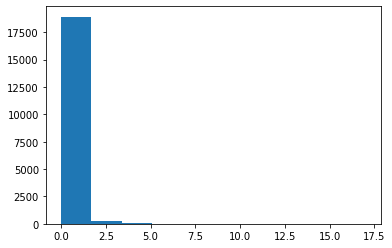

In [13]:
plt.hist(races_featurized_weather['rain'])

(array([1.6319e+04, 7.3000e+02, 7.2500e+02, 0.0000e+00, 2.2000e+02,
        3.0300e+02, 1.2000e+02, 0.0000e+00, 1.1600e+02, 6.4000e+01,
        4.5000e+01, 9.9000e+01, 0.0000e+00, 9.7000e+01, 0.0000e+00,
        3.9000e+01, 6.7000e+01, 0.0000e+00, 5.4000e+01, 0.0000e+00,
        1.4000e+01, 1.8000e+01, 3.0000e+01, 2.1000e+01, 0.0000e+00,
        9.0000e+00, 1.2000e+01, 2.9000e+01, 7.0000e+00, 0.0000e+00,
        8.0000e+00, 8.0000e+00, 8.0000e+00, 1.0000e+00, 0.0000e+00,
        3.0000e+00, 9.0000e+00, 1.2000e+01, 6.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 6.0000e+00, 0.0000e+00, 4.0000e+00,
        2.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00, 3.0000e+00,
        3.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00, 5.0000e+00,
        5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.00

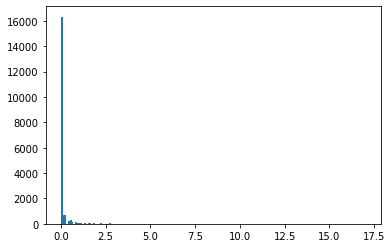

In [14]:
binwidth = 0.1
n = math.ceil(max(races_featurized_weather['rain'] - min(races_featurized_weather['rain']))/binwidth)

plt.hist(races_featurized_weather['rain'], bins=n)

(array([1.9231e+04, 1.4000e+01, 3.0000e+00]),
 array([ 0.        ,  5.66666667, 11.33333333, 17.        ]),
 <BarContainer object of 3 artists>)

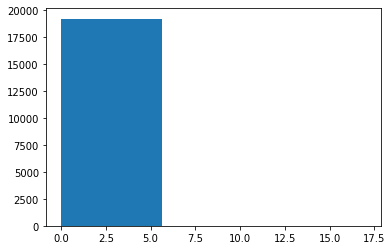

In [15]:
plt.hist(races_featurized_weather['rain'], bins=3)

In [16]:
np.mean(races_featurized_weather['rain'] <= 0)

0.8478283458021613

All of this exploratory data analysis suggest there are very few entries with rain, and that there is not a clear or useful way to divide this into different bins, so we will have to instead settle for just using the lack or presence of rain as a feature.

In [22]:
races_featurized_weather['is_raining'] = [int(elt) for elt in (races_featurized_weather['rain'] > 0)]
races_featurized_weather.sample(10)

,rid,metric,margin,temp,msl,rain,rhum,course__Ballinrobe,course__Bellewstown,course__Clonmel,...,pressure_level_1,pressure_level_2,pressure_level_3,pressure_level_4,is_raining,rhum_level_0,rhum_level_1,rhum_level_2,rhum_level_3,rhum_level_4
11082,333880,1407.0,1.080170,10.3,1004.5,0.1,73,0,0,0,...,0,1,0,0,1,0,0,0,1,0
17456,161999,2413.0,1.299383,18.8,1005.2,0.0,65,0,0,0,...,0,1,0,0,0,0,0,1,0,0
10595,376651,2413.0,1.231151,14.3,1018.9,0.0,80,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6746,260378,4122.5,1.186275,15.6,1003.8,0.0,89,0,0,0,...,0,1,0,0,0,0,0,0,0,1
18728,109560,2413.0,1.169513,12.4,1024.3,0.0,64,0,0,0,...,0,0,1,0,0,0,0,1,0,0
9862,391780,2011.0,1.239364,15.9,1009.1,0.0,84,0,0,1,...,0,1,0,0,0,0,0,0,1,0
5524,232234,2614.0,1.378642,12.3,994.4,1.3,93,0,0,0,...,0,1,0,0,1,0,0,0,0,1
2860,258427,3419.0,1.204139,12.3,1004.7,0.0,76,0,1,0,...,0,1,0,0,0,0,0,0,1,0
11888,223079,1609.0,1.127381,16.4,1019.8,0.0,73,0,0,0,...,0,0,1,0,0,0,0,0,1,0
10752,243088,2011.0,1.106528,17.0,1016.9,0.0,85,0,0,0,...,0,0,1,0,0,0,0,0,0,0


---

## Bin Humidity

We again resort to our previous method of using 5 bins.

(array([  96., 1224., 5105., 6909., 5914.]),
 array([ 25.,  40.,  55.,  70.,  85., 100.]),
 <BarContainer object of 5 artists>)

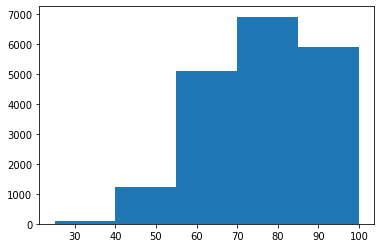

In [18]:
plt.hist(races_featurized['rhum'], bins=5)

In [19]:
# cutoffs obtained from the histogram
humidity_cutoffs = [25., 40., 55., 70., 85., 100.]

In [20]:
for idx in range(len(temp_cutoffs[:-1])):
    colname = "rhum_level_" + str(idx)
    in_bucket = np.logical_and(races_featurized_weather['rhum'] > humidity_cutoffs[idx],
                               races_featurized_weather['rhum'] < humidity_cutoffs[idx + 1])
    races_featurized_weather[colname] = [int(elt) for elt in in_bucket]

races_featurized_weather.head(10)

,rid,metric,margin,temp,msl,rain,rhum,course__Ballinrobe,course__Bellewstown,course__Clonmel,...,pressure_level_1,pressure_level_2,pressure_level_3,pressure_level_4,is_raining,rhum_level_0,rhum_level_1,rhum_level_2,rhum_level_3,rhum_level_4
0,302858,3821.0,1.219263,2.2,1012.7,0.0,82,0,0,0,...,0,0,1,0,False,0,0,0,1,0
1,291347,5229.0,1.218049,8.1,992.8,0.0,79,0,0,0,...,0,1,0,0,False,0,0,0,1,0
2,377929,1609.0,1.204927,10.1,996.7,0.0,76,0,0,0,...,0,1,0,0,False,0,0,0,1,0
3,275117,2011.0,1.083838,15.8,1030.1,0.0,53,0,0,0,...,0,0,0,1,False,0,1,0,0,0
4,66511,1810.0,1.077871,16.3,1022.9,0.0,53,0,0,0,...,0,0,1,0,False,0,1,0,0,0
5,337765,2011.0,1.102020,15.5,992.0,0.0,85,0,0,0,...,0,1,0,0,False,0,0,0,0,0
6,353432,1407.0,1.178877,14.0,1004.5,0.0,94,0,0,0,...,0,1,0,0,False,0,0,0,0,1
7,362433,2011.0,1.168184,15.7,1010.1,0.0,71,0,0,0,...,0,0,1,0,False,0,0,0,1,0
8,326282,1206.0,1.153438,15.0,1012.0,0.0,76,0,0,0,...,0,0,1,0,False,0,0,0,1,0
9,42648,2815.0,1.243313,16.1,1010.9,0.0,75,0,0,0,...,0,0,1,0,False,0,0,0,1,0


---

## Save Dataframes

In [23]:
races_featurized_weather.to_csv(f"{BASE_DIR}/data/csv/races_featurized_weather.csv", index=False)

---